# 3I026 - Intelligence artificielle & Data science

# Projet

## Données

Vous devez travailler sur les données du projet Kaggle *European Soccer Database* accessible à l'adresse https://www.kaggle.com/hugomathien/soccer.

Les données en version SQLite sur la page http://www-connex.lip6.fr/~schwander/3I026/soccer.zip ou en version CSV http://www-connex.lip6.fr/~denoyer/wordpress/wp-content/uploads/2018/01/soccer.tar.gz. Pour facilter le travail dans les salles de la PPTI (et éviter de dépasser le quota de votre home), les données sont accessibles aussi dans `/Vrac/3I026/soccer/`.

Quel que soit le moyen pour récupérer le fichier de données, il est indispensable de lire en détail la page Kaggle pour comprendre à quoi ces données correspondent.

**Rappel:** il est attendu un notebook Python par problème, et le problème étudié doit être décrit précisément. Votre rapport devra impérativement suivre le format suivant.

## Partie 1 - Description du problème

Le but de ce notebook est de séparé les joueurs en plein expension dans leurs carriere, et ceux qui ne le sont pas. Donc en donnant au modèle le plus ancien potentiel d'un joueur, le plus récent et son age par rapport a une date et devras prédire +1 si le joueur compte évoluer ou -1 sinon.

## Partie 2 - Modéle

* imports

In [1]:
import random
import numpy as np
import pandas as pd
import math
import graphviz
import datetime
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt

* Modèle

In [2]:
class Classifier:
    def __init__(self,input_dimension):
        """ Constructeur """
        raise NotImplementedError("Please Implement this method")
    
    
    # Permet de calculer la prediction sur x => renvoie un score
    def predict(self,x):
        raise NotImplementedError("Please Implement this method")

    
    # Permet d'entrainer le modele sur un ensemble de données étiquetés
    def train(self,labeledSet):
        raise NotImplementedError("Please Implement this method")
    
    # Permet de calculer le taux de bonne classification
    def accuracy(self,set):
        nb_ok=0
        for i in range(set.size()):
            score = self.predict(set.getX(i))
            if (score*set.getY(i)>0):
                nb_ok = nb_ok+1
        acc = nb_ok/(set.size() * 1.0)
        return acc


## Partie 3 - Code

* Lecture des tables 

In [3]:
country = pd.read_csv("soccer/country.csv")
league = pd.read_csv("soccer/league.csv")
player = pd.read_csv("soccer/player.csv")
team = pd.read_csv("soccer/team.csv")
playerattributes = pd.read_csv("soccer/playerattributes.csv")
teamattributes = pd.read_csv("soccer/teamattributes.csv")
match = pd.read_csv("soccer/match.csv")

* Fonctions utiles

In [4]:
def isNaN(x):
    return str((x)).lower() == 'nan'

In [5]:
def normalisation(data):    
    for i in data.columns:
        min1 = data[i].min()
        data[i] = [(row-min1)/(data[i].max()-min1) for row in data[i]]        
    return data

In [6]:
def dist_vect(v1, v2):
    return math.sqrt((((v1)-(v2))**2).sum())

In [7]:
def centroide(examples):
    return pd.DataFrame({'X': [(examples['X'].max()+examples['X'].min())/2], 'Y': [(examples['Y'].max()+examples['Y'].min())/2]})

In [8]:
def medoide(examples):
    Dframe=pd.DataFrame()
    for col in examples.columns:
        Dframe[col]=([examples[col].mean()])
    return Dframe   

In [9]:
def inertie_cluster(data):
    centre=medoide(data)
    inertie=0
    for i in range(len(data)):
        inertie+=dist_vect(data.iloc[i], medoide(data).iloc[0])**2
    return inertie    

In [10]:
def initialisation(k, data):
    index=random.sample(range(len(data)), k)
    dt=pd.DataFrame()
    for col in data.columns:
        dt[col]=[]
    for i in np.arange(0, k):
        dt.loc[index[i]] = (data.iloc[index[i]])
    return dt

In [11]:
def plus_proche(example, dataframe):
    l = [dist_vect(example, dataframe.iloc[i]) for i in range(dataframe.shape[0])]              
    return np.argsort(l)[0]

In [12]:
def affecte_cluster(app, centroides):
    res = dict()
    for i in range(centroides.shape[0]):
        res[i] = list()
    for i in range(app.shape[0]):
        k = plus_proche(app.iloc[i], centroides)
        res[k].append(i)
    return res

In [13]:
def nouveaux_centroides(app, mat):
    centres = pd.DataFrame()
    for col in app.columns:
        centres[col]=[]    
    for i in range(len(mat)):
        dt = pd.DataFrame()
        for col in app.columns:
            dt[col]=[]
        for j in range(len(mat[i])):
            dt.loc[j] = app.iloc[mat[i][j]]
        centres.loc[i] = medoide(dt).iloc[0]
    return centres
   

In [14]:
def inertie_globale(dataframe,matrice):
    s=0
    for i in matrice:
        df=dataframe.iloc[matrice[i],]
        s+=inertie_cluster(df)
    return s
        
    

In [15]:
def kmoyennes(k, app, epsilon, iter_max):
    if k < 1 or epsilon <= 0 and iter_max < 1:
        print("erreur sur les arguments")
        return None
    centroides = initialisation(k, app)
    it = 0
    iner_glob_last = 0
    mat = affecte_cluster(app, centroides)
    iner_glob_new = inertie_globale(app, mat)
    differance_inertie=epsilon+1
    while (differance_inertie > epsilon) and it <= iter_max:
        centroides = nouveaux_centroides(app, mat)
        mat = affecte_cluster(app, centroides)        
        iner_glob_last = iner_glob_new
        iner_glob_new = inertie_globale(app, mat)
        differance_inertie=abs(iner_glob_new - iner_glob_last)
        it+=1
    return centroides, mat

In [16]:
def plot3DSet(set):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    S_pos = set.x[np.where(set.y == 1),:][0]      # tous les exemples de label +1
    S_neg = set.x[np.where(set.y == -1),:][0]     # tous les exemples de label -1
    ax.scatter3D(S_pos[:,0], S_pos[:,1], S_pos[:,2], c="green");
    ax.scatter3D(S_neg[:,0], S_neg[:,1], S_neg[:,2], c="blue");



In [35]:
def affiche_resultat(data, centres, affects):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    dt = pd.DataFrame({'new_pot': [], 'old_pot': [], 'age': []})
    for i in range(len(affects)):
        for j in range(len(affects[i])):
            dt.loc[j] = data.iloc[affects[i][j]]
        ax.scatter3D(dt['new_pot'], dt['old_pot'], dt['age'], c = np.random.rand(3))
        dt = pd.DataFrame({'new_pot': [], 'old_pot': [], 'age': []})
    ax.scatter3D(centres['new_pot'],centres['old_pot'],centres['age'],c='blue',marker='x')   


In [36]:
def affiche_resultat_2D(data, centres, affects):
    dt = pd.DataFrame({'new_pot': [], 'old_pot': []})
    for i in range(len(affects)):
        for j in range(len(affects[i])):
            dt.loc[j] = data.iloc[affects[i][j]]
        plt.scatter(dt['new_pot'], dt['old_pot'], color = np.random.rand(3))
        dt = pd.DataFrame({'new_pot': [], 'old_pot': []})
    plt.scatter(centres['new_pot'],centres['old_pot'],color='r',marker='x')   
    plt.show()

In [44]:
#predire les prochains meilleures buteurs
def dfSetAgePotAm(date_actuel):
    finalSet=pd.DataFrame(columns=('new_pot', 'old_pot', 'age'))
    for i in range(len(player)):
        idJ = player["player_api_id"][i]
        l = playerattributes[(playerattributes["player_api_id"]==idJ) & (playerattributes["date"]<date_actuel)]["potential"]
        old_pot = l.iloc[len(l)-1]
        new_pot = l.iloc[0]
        amelioration = new_pot-old_pot
        annee_naissance = int(player["birthday"][i][0:4])
        age = int(str(date_actuel)[0:4])-annee_naissance
        finalSet.loc[i]=[new_pot, old_pot, age]
    return finalSet

* Variables globales

In [45]:
date_actuel = datetime.date(2014,1,1)
playerattributes['date']  = pd.to_datetime(playerattributes['date'])

In [46]:
theSet = dfSetAgePotAm(date_actuel)

## Partie 4 - Protocole expérimental

In [47]:
centroides,matrice=kmoyennes(2,theSet,0.05,100)

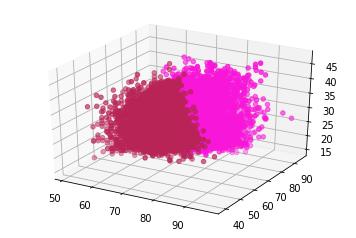

In [48]:
affiche_resultat(theSet, centroides, matrice)

## Partie 5 - Résultats

### recuperer la fonction affiche bien ce type la

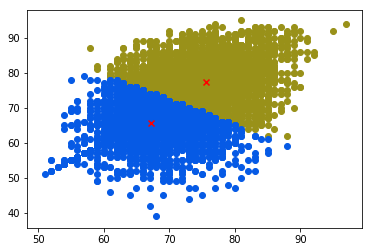

In [49]:
affiche_resultat_2D(theSet, centroides, matrice)

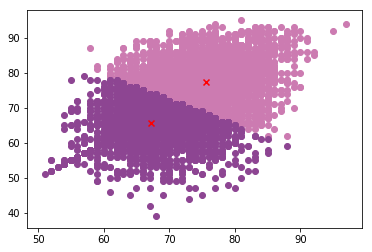

In [50]:
affiche_resultat_2D(theSet, centroides, matrice)

## Partie 6 - Analyse

On remarque bien que notre algorithme KMoyennes a séparé nos données en deux groupes, le groupe de joueurs qui ont des similarités sur leurs caractéristiques d'évolution sont supposé pour un groupe joueurs en plein évolution, et l'autre en régression dans leur carriere et n'ont donc pas de meilleur potentiel les saisons a venir. <br>
Finalement les résultats ne sont pas concluent car le nos données ne sont pas idéales pour ce type de classifiers, en effet le clustering n'apprend pas sur nos données et donc prend en comptes les attributs donnés en tant que coordonnées mathématiques. Dans notre cas l'ancien potentiel, le nouveau et l'age n'aident pas assez à classer nos joueurs.